# Contrastive Learning with 3D Shapes



## Install and Import standard libraries

In [1]:
# Install the right version of PyTorch for Kaggle notebooks
!python -m pip install torch==1.12.1+cu113 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 521.0 kB/s eta 0:00:000:0100:02
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0


In [2]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print("torch verion: ", torch.__version__)

# Install required packages.
# Install torch-geometric to deal with Point Cloud
!python -m pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!python -m pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!python -m pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!python -m pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!python -m pip install -q torch-geometric -f https://data.pyg.org/whl/torch-${TORCH}.html
!python -m pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# See https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#ntxentloss
!python -m pip install pytorch-metric-learning -q 

# TensorBoard
!python -m pip install tensorboard

torch verion:  1.12.1+cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.8 MB/s eta 0:00:0000:0100:01


In [4]:
import torch_geometric
torch_geometric.__version__

'2.2.0'

In [6]:
# PyTorch Geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool

# PyTorch
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import TensorDataset
from torch.nn import Linear

# Plot 3D Shape
import plotly.graph_objects as go

# Loss
from pytorch_metric_learning.losses import NTXentLoss

# Generic
import numpy as np
import random
import pandas as pd
import os.path as osp
from copy import deepcopy
from tqdm.notebook import tqdm

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
# Get the number of workers
NUM_WORKERS = os.cpu_count()
# Get the type of device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set the seed for reproducibility
torch.manual_seed(12345)

print("Device:", DEVICE)
print("Number of workers:", NUM_WORKERS)

Device: cuda
Number of workers: 2


## Dataset

In [9]:
# Dataset Path
DATASET_PATH = "data/ShapeNet"

# Model Path
MODEL_PATH = "data/ContrastiveModel"

# Max number of samples for each category
MAX_NUMBER = 200

# Dataset Category 
CATEGORIES = ["Airplane", "Pistol", "Car", "Chair", "Motorbike", "Guitar", "Knife", "Lamp", "Laptop", "Table"]

# Batch Size, max to avoid RAM problem is 64
BATCH_SIZE = 64 

# Number of epochs: 50 for the contrastive learning anf 100 for the classification
EPOCHS = 50 # 100

### Dataset Analysis

The PyTorch geometric library contains a large number of common benchmark datasets regarding 3D figures. For my project, I decided to use [`ShapeNet`](https://shapenet.org/), a dataset containing 3D shape point clouds from 16 shape categories.

All possible categories of 3D models are:
  - `Airplane`, `Bag`, `Cap`, `Car`, `Chair`, `Earphone`, `Guitar`, `Knife`,`Lamp`, `Laptop`, `Motorbike`, `Mug`, `Pistol`, `Rocket`, `Skateboard`, `Table`.

I selected the 10 categories with the highest number of samples.

In [7]:
dataset = ShapeNet(root="data/ShapeNet", categories=CATEGORIES)

In [8]:
# Structure of each element
print("Sample: ", dataset[0])

Sample:  Data(x=[2252, 3], y=[2252], pos=[2252, 3], category=[1])


We are interested in the content of the `pos` and `category` attributes, which are the normalized positions as 3D coordinates and the label respectively.

In [9]:
# Plot function
def visualize_3d_shape(pos): 
  pos = pos.cpu()  
  fig = go.Figure(data=[go.Scatter3d(x=pos[:, 0], 
                                     y=pos[:, 1], 
                                     z=pos[:, 2],
                                     mode='markers')])
  fig.show()

In [10]:
# Choose a Random sample
sample_idx = random.randrange(0, len(dataset))
print("Sample number: ", sample_idx)

visualize_3d_shape(dataset[sample_idx].pos)

Sample number:  11569


### Data Augmentation

In this section we define the augmentation procedure that we will use during the train of our model. 

For the code I took a cue from [`dgcnn_segmentation.py`](https://github.com/pyg-team/pytorch_geometric/blob/a6e349621d4caf8b381fe58f8e57109b2d0947ed/examples/dgcnn_segmentation.py) and [`dgcnn_classification.py`](https://github.com/pyg-team/pytorch_geometric/blob/a6e349621d4caf8b381fe58f8e57109b2d0947ed/examples/dgcnn_classification.py), two examples available on the GitHub repository of the Pytorch Geometric library.

This part is very important because, if it is not applied in the right way, it introduces a strong **Bias**. For example, with point cloud samples, the `Rotation` is problematic because, depending on the layer we use, some of the layers might be rotation invariants, so this augmentation won't have any effect. 

Good augmentations for this type of sample are `Jittering` (which translates node positions by randomly sampling translation values within a given interval), `Shifting`, and `Shearing` (which shift in one dimension).

Before applying the augmentation, however, we normalize the scale of each figure and reduce the number of points (to increase the batch size), with the `FixedPoints`, that samples a fixed number of num points and features from a point cloud

Initially my idea was to use the `SamplePoints` instead of the `FixedPoints`, however I encountered a bug in `sample_point.py`, which from what I've seen hasn't been fixed yet.

I link to the same bug just for another method (`face_to_edge.py`) which was reported on GitHub: [GitHub Issues](https://github.com/rusty1s/deep-graph-matching-consensus/issues/15).

In [11]:
# `Compose` allow us to compose several transforms together.
augmentation = T.Compose([T.RandomJitter(translate=0.05),
                          T.RandomFlip(axis=1),
                          T.RandomShear(shear=0.2),
                          T.RandomRotate(degrees=15, axis=0),
                          T.RandomRotate(degrees=15, axis=1),
                          T.RandomRotate(degrees=15, axis=2)])

transformer = T.Compose([T.NormalizeScale(),
                         T.FixedPoints(num=800),
                         T.ToDevice(DEVICE)
                         ])

In [12]:
# Original data point
visualize_3d_shape(dataset[sample_idx].pos)

In [13]:
# Transformed data point
transformed = transformer(dataset[sample_idx])
visualize_3d_shape(transformed.pos)

Let's see how the number of points has decreased significantly...

In [14]:
print("Before:", len(dataset[sample_idx].pos), "  After:", len(transformed.pos))

Before: 2713   After: 800


In [15]:
# Augmented data point
augmented = augmentation(transformed)
visualize_3d_shape(augmented.pos)

### Undersampling


For problems due to the amount of RAM I decided to select only a sub-set of these samples, that is, 200 samples for each category.

Shows the number of occurrences for each category:

In [16]:
# Build Dict
def build_dict(dataset):
  # Create a dictionary to store the occurrences of each category
  categories = dataset.categories 
  number_of_samples = [0 for i in range(len(CATEGORIES))]
  categories_occurrence = dict(zip(categories, number_of_samples))
  return categories_occurrence
  
def get_category(dataset):
  categories_occurrence = build_dict(dataset)

  # Compute the occurrences
  for sample in dataset:
    cat_str = dataset.categories[sample[0].category]
    categories_occurrence[cat_str]+= 1  
  return categories_occurrence

In the next cell we build our customized dataset, where for each sample, we have two different augmented versions.

In [17]:
class AugmentedShapeNet(Dataset):
  def __init__(self, augmentation, transformer, categories):
    train_set = ShapeNet(root="data/ShapeNet", split="train", categories=categories)
    self.categories = train_set.categories 
    self.transformer = transformer
    self.augmentation = augmentation
    self.dataset = self.undersampling(train_set)
   
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, id):
    shape = self.dataset[id]
    shape = self.transformer(shape.clone())
    augmented_shape_1 = self.augmentation(shape.clone()) 
    augmented_shape_2 = self.augmentation(shape.clone())
    return shape, augmented_shape_1, augmented_shape_2
  
  def undersampling(self, dataset):
    # Create a dictionary to store the occurrences of each category
    categories = dataset.categories 
    number_of_samples = [0 for i in range(len(CATEGORIES))]
    categories_occurrence = dict(zip(categories, number_of_samples))
    # Compute the occurrences
    sampled_dataset = []
    for sample in  dataset :
      cat_str = dataset.categories[sample.category]
      if categories_occurrence[cat_str] < MAX_NUMBER:
        categories_occurrence[cat_str]+= 1
        sampled_dataset.append(sample)
    return sampled_dataset

    

In [18]:
del dataset

In [19]:
# Train Set
train_set = AugmentedShapeNet(augmentation, transformer, CATEGORIES)
print("Sample for each category after under-sampling:", get_category(train_set))

# Validation Set
test_set = ShapeNet(root="data/ShapeNet", split="test", categories=CATEGORIES)

Sample for each category after undersampling: {'Airplane': 200, 'Pistol': 200, 'Car': 200, 'Chair': 200, 'Motorbike': 125, 'Guitar': 200, 'Knife': 200, 'Lamp': 200, 'Laptop': 200, 'Table': 200}


## Model

One of the main problems of the project is how to manage the 3D point cloud. To do this, it is possible to take different approaches such as `Voxelization` (which is not very efficient) or `Multi-View`, i.e. look at the object from different angles and take 2D photos to use as input for a CNN. The latter approach is more efficient than the former, but we don't really use 3D information. 

However, there are Deep Learning models that can operate directly on the point cloud itself, thanks to the fact that they are invariant with respect to permutations and therefore to the ordering of points. 

Examples of these models are: `PPFNet`, `PointNet`/`Pointnet++`, `EdgeConv`/`DynamicEdgeConv`.

From [Medium](https://medium.com/@sanketgujar95/dynamic-graph-cnn-edge-conv-2582c3eb18d8): *EdgeConv is inspired from PointNet and convolutional operations, but instead of working on individual points it exploits the geometric structure by constructing a local neighborhood graph and applying convolution-like operation on the edge connecting the neighborhood pair of points. It thus has the property of translation-invariant and non-locality.*

To use these Convolutional Layers correctly I used the code of the examples [1](https://github.com/pyg-team/pytorch_geometric/blob/a6e349621d4caf8b381fe58f8e57109b2d0947ed/examples/dgcnn_segmentation.py), [2](https://github.com/pyg-team/pytorch_geometric/blob/a6e349621d4caf8b381fe58f8e57109b2d0947ed/examples/dgcnn_classification.py),  mentioned in the previous section, provided by the Pytorch Geometric library.

To develop the architecture of my model, I took ispiration from [SimCLR](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb#scrollTo=nRRiSml1GhVQ) and [Tutorial 3: Train SimCLR on Clothing](https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html) where an **End-to-End** architecture is used, in which the authors generate two views of an image, so they do not use the original data point but attract and reject the representations of all the augmented images. This prevents the model from learning how an image was augmented.



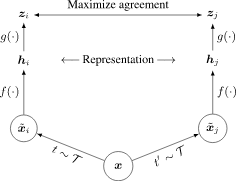

For each sample $x$, we generate two augmented versions ($\tilde{x} _i $ and $ \tilde{x}_j $), which we will pass to the encoder $f(\cdot)$, consisting of two `DynamicEdgeConv` layers. 

Then we pass this to the `Projection Head` $g(\cdot)$, a fully connected network, that maps the representation $h$ into a smaller space where we apply the loss function. The reason why it is necessary to apply the Projection Head is that most similarity measures that are used in contrastive losses suffer from the curse of dimensionality. 

Therefore, when we calculate the `loss` on smaller vectors, we will get better results.

In [20]:
class ContrastiveModel(torch.nn.Module):
  def __init__(self, k=40, aggr='max'):
    super().__init__()

    # ENCODER
    self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
    self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr) 
    self.lin1 = Linear(128 + 64, 128)

    # PROJECTION HEAD 
    self.project_head = MLP([128, 256, 10], norm=None)


  def get_representation(self, x):
    x1 = self.conv1(x.pos, x.batch)
    x2 = self.conv2(x1, x.batch)
    # Global representation
    h1 = self.lin1(torch.cat([x1, x2], dim=1))
    h2 = global_max_pool(h1, x.batch)
    return h2

  def forward(self, original=None, x_i=None, x_j=None, train=True):
    if not train:
      h = self.get_representation(original) 
      return h

    # Apply Encoder, get representation
    h_i = self.get_representation(x_i) 
    h_j = self.get_representation(x_j) 

    # Apply Projection Head, get lower space representation
    z_i = self.project_head(h_i)
    z_j = self.project_head(h_j)

    return z_i, z_j

## Training

As Loss function I used the `NTXent Loss`, sometimes also called `InfoNCE`, which is implemented in the [PyTorch Metric Learning](https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#ntxentloss) library, which has the `Temperature` as hyperparameter which helps to balance the similarity measure.

In short, the NTXent Loss compares the similarity of $z_i = g(h_i)$ and  $z_j = g(h_j)$,  to the similarity of $z_i$ to any other representation in the batch $z_k$, by performing a *softmax* over the similarity values. The loss can be formally written as:

$$\mathcal{L}_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}$$

where $\tau$ is the *temperature*, $\mathbb{1}_{[k \neq i]}$ is an indicator function (1 if $k\neq i$ 0 otherwise), and $sim()$ is the application of Cosine Similarity.

In [21]:
def train_contrastive_learning(dataset, model, optimizer, loss_func, batch_size=BATCH_SIZE):
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  model.train()
  total_loss = 0
  for _, data in enumerate(tqdm(data_loader)):
    original, x_i, x_j = data
    optimizer.zero_grad()

    # Get representation into a smaller space 
    z_i, z_j = model(original=original, x_i=x_i, x_j=x_j)

    # Concatenate two output in a single tensor
    z = torch.cat((z_i, z_j))

    # From each batch we get two sets of augmented samples, the related images 
    # are in the same position in the two batches, so I create an index list 
    # with size equal to that of the batch and concatenate it to itself. 
    # So related images will have the same index.
    idx = torch.arange(start=0, end=z_i.size(0), device=z_j.device)
    labels = torch.cat((idx, idx))

    # Compute Loss
    loss = loss_func(z, labels)
    loss.backward()
    total_loss += loss.item() * x_i.num_graphs
    optimizer.step()
  return total_loss / len(dataset)


In [22]:
cl_model = ContrastiveModel().to(DEVICE)
cl_optimizer = torch.optim.Adam(cl_model.parameters(), lr=0.001)
cl_scheduler = torch.optim.lr_scheduler.StepLR(cl_optimizer, step_size=20, gamma=0.5)
cl_loss_func = NTXentLoss(temperature=0.07)

In [ ]:
log_for_csv = []
for epoch in range(1, EPOCHS+1):
  loss = train_contrastive_learning(train_set, cl_model, cl_optimizer, cl_loss_func)
  print(f'Epoch: {epoch}, Loss: {loss:.4f}')
  log_for_csv.append([epoch, loss])
  cl_scheduler.step()

# Write CSV
df = pd.DataFrame(log_for_csv, columns=["Epoch", "Loss"])
df.to_csv('contrast_learning.csv', index=False, header=False)

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df.Epoch, 
                         y=df.Loss, 
                         line=dict(color='orange', width=2)))

# Edit the layout
fig.update_layout(title='Contrastive Learning Loss',
                   xaxis_title='Epoch',
                   yaxis_title='Loss', width=500, height=400)


fig.show()

In [31]:
# SAVE MODEL
torch.save(cl_model.state_dict(), MODEL_PATH)

In [32]:
# LOAD MODEL
# cl_model = ContrastiveModel().to(DEVICE)
# cl_model.load_state_dict(torch.load(MODEL_PATH))

##  Downstream Tasks

For the test phase, we will use the **DownStream** approach to see how the model performs with small data.
As for the SimCLR implementation, I will use the Logistic Regression, to see if the model generalizes well, to which we will pass the 3D elements that have already been processed by our $f(\cdot)$ function, i.e. encoded in their feature vector, which will associate the representations with a class prediction.

In [33]:
class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(in_features=128, out_features=10)
    
  def forward(self, x):
    outputs = torch.sigmoid(self.linear(x))
    return outputs

In [34]:
def train_classifier(contrastive_model, log_reg_model, loss_fun, optimizer, loader):
  log_reg_model.train()
  total_loss = 0
  for _, data in enumerate(tqdm(loader)):
    original, _, _ = data
    optimizer.zero_grad()
    h = contrastive_model(original=original, train=False)
    out = log_reg_model(h)
    loss = loss_fun(out, original.category)
    loss.backward()
    total_loss += loss.item() * original.num_graphs
    optimizer.step()
  return total_loss / len(train_set)


def test_classifier(contrastive_model, log_reg_model, loader):
  log_reg_model.eval()
  correct = 0
  for _, data in enumerate(tqdm(loader)):
    data = data.to(DEVICE)
    with torch.no_grad():
      h = contrastive_model(original=data, train=False)
      logits = log_reg_model(h)
      pred = torch.argmax(logits, dim=-1)
    correct += pred.eq(data.category).sum().item()
  return correct / len(loader.dataset)

In [35]:
lr_model = LogisticRegression().to(DEVICE)
lr_loss_func = torch.nn.CrossEntropyLoss()
lr_optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(lr_optimizer, step_size=20, gamma=0.5)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
log_for_csv = []

for epoch in range(1, EPOCHS+1):
  loss = train_classifier(cl_model, lr_model, lr_loss_func, lr_optimizer, train_loader)
  test_acc = test_classifier(cl_model, lr_model, test_loader)
  print(f'Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {test_acc:.4f}')
  log_for_csv.append([epoch, loss, test_acc])
  lr_scheduler.step()

# Write CSV
df = pd.DataFrame(log_for_csv, columns=["Epoch", "Loss", "Accuracy"])
df.to_csv('logistic_regression.csv', index=False, header=False)

In [ ]:
# df = pd.read_csv('/kaggle/working/logistic_regression.csv', names=["Epoch", "Loss", "Accuracy"])
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df.Epoch, 
                         y=df.Loss, 
                         line=dict(color='orange', width=2)))

# Edit the layout
fig.update_layout(title='Logistic Regression Loss',
                   xaxis_title='Epoch',
                   yaxis_title='Loss', width=500, height=400)


fig.show()

In [ ]:
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=df.Epoch, 
                         y=df.Accuracy, 
                         line=dict(color='orange', width=2)))

# Edit the layout
fig.update_layout(title='Logistic Regression Accuracy',
                   xaxis_title='Epoch',
                   yaxis_title='Accuracy', width=500, height=400)

fig.show()